In [292]:
import os
import time
import sys
import scipy
import glob
import importlib

import pandas as pd
import numpy as np

import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl

from datetime import datetime

# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as util
import behavior as butil

In [293]:
from pathlib import Path
import tifffile as tf
import re
import cv2

import pprint
pp = pprint.PrettyPrinter(indent=4)

In [294]:
util.set_sns_style(style='dark')
%matplotlib notebook

In [296]:
rootdir = '/Volumes/Julie/plume-tracking'
experiment = 'stripgrid'
session = '20221102'
# get source
src_dir = os.path.join(rootdir, session, 'raw')
# Create output dir for figures
dst_dir = os.path.join(rootdir, session, 'processed')
print("Saving figures to:{}    {}".format('\n', dst_dir))
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
    
# create fig ID
fig_id = os.path.join(experiment, session)
print("Fig ID: {}".format(fig_id))

Saving figures to:
    /Volumes/Julie/plume-tracking/20221102/processed
Fig ID: stripgrid/20221102


In [297]:
fly_id = 'fly4'
# check if anatomicals
# anat_dirs = glob.glob(os.path.join(src_dir, '*{}_anatomical*'.format(fly_id)))
anat_fns = glob.glob(os.path.join(src_dir, '*{}_anatomical*.tif'.format(fly_id)))
assert len(anat_fns)==1, "Found {} anatomicals...".format(len(anat_fns))
anat_fn = anat_fns[0]
print("Found {} anatomical path: {}{}".format(len(anat_fns), '\n', anat_fn))
# check if functionals
func_paths = glob.glob(os.path.join(src_dir, '*{}_{}*'.format(fly_id, experiment)))
#func_paths
# imdirs = sorted([p for p in func_fns if Path(p).is_dir()], key=util.natsort)
tf_fns = sorted([p for p in func_paths if p.endswith('.tif')])
ft_fns = sorted([p for p in func_paths if p.endswith('.log')])
assert len(ft_fns)==len(tf_fns), \
"Incorrect fictrac files (n={}) and tif files (n={})".format(len(ft_fns), len(tf_fns))
print("Found {} functional runs".format(len(tf_fns)))

Found 1 anatomical path: 
/Volumes/Julie/plume-tracking/20221102/raw/TSeries-11022022-1844_hdc-split-sytGCaMP7f-60D05_fly4_anatomical-001.tif
Found 1 functional runs


In [275]:
filedict={}
anat_fns = sorted(glob.glob(os.path.join(os.path.splitext(anat_fn)[0], '*.tif')), key=util.natsort)
datestr_anat = datetime.fromtimestamp(os.path.getmtime(anat_fns[0])).strftime('%Y%M%d-%H%M%S')
    
filedict.update({0: {'image_dir': os.path.splitext(anat_fn)[0], 
                     'tif_stack': anat_fn,
                     'im_tstamp': datestr_anat,
                    }
                })
for fi, (tf_fn, ft_fn) in enumerate(zip(tf_fns, ft_fns)):
    tf_dir = os.path.splitext(tf_fn)[0]
    imfns = sorted(glob.glob(os.path.join(tf_dir, '*.tif')), key=util.natsort)
    datestr_2p = datetime.fromtimestamp(os.path.getmtime(imfns[0])).strftime('%Y%M%d-%H%M%S')
    datestr_ft = datetime.fromtimestamp(os.path.getmtime(ft_fn)).strftime('%Y%M%d-%H%M%S')
    filedict.update({(fi+1): {'image_dir': tf_dir, 
                              'tif_stack': tf_fn,
                              'im_tstamp': datestr_2p,
                              'ft_fpath': ft_fn,
                              'ft_tstamp': datestr_ft
                              }})
pp.pprint(filedict)

{   0: {   'im_tstamp': '20222102-192107',
           'image_dir': '/Volumes/Julie/plume-tracking/20221102/raw/TSeries-11022022-1844_hdc-split-sytGCaMP7f-60D05_fly4_anatomical-001',
           'tif_stack': '/Volumes/Julie/plume-tracking/20221102/raw/TSeries-11022022-1844_hdc-split-sytGCaMP7f-60D05_fly4_anatomical-001.tif'},
    1: {   'ft_fpath': '/Volumes/Julie/plume-tracking/20221102/raw/11022022-184822_hdc-sytGCaMP7f_fly4_stripgrid_2p.log',
           'ft_tstamp': '20220802-190844',
           'im_tstamp': '20221102-191149',
           'image_dir': '/Volumes/Julie/plume-tracking/20221102/raw/TSeries-11022022-1844_hdc-split-sytGCaMP7f-60D05_fly4_stripgrid-001',
           'tif_stack': '/Volumes/Julie/plume-tracking/20221102/raw/TSeries-11022022-1844_hdc-split-sytGCaMP7f-60D05_fly4_stripgrid-001.tif'}}


## view anatomical

In [276]:
import imaging as ig

In [277]:
importlib.reload(util)
importlib.reload(ig)

<module 'imaging' from '/Users/julianarhee/Repositories/plume-tracking/imaging.py'>

## plot anatomical

In [279]:
importlib.reload(ig)

<module 'imaging' from '/Users/julianarhee/Repositories/plume-tracking/imaging.py'>

In [280]:
anat = ig.ImageStack(os.path.splitext(anat_fn)[0], n_slices=25, n_volumes=100)

/Users/julianarhee/miniforge3/envs/plume/lib/python3.9/site-packages/tifffile/tifffile.py:12998: RuntimeWarning: invalid value encountered in divide
  'ZDistance': values[:, 0] / values[:, 1],


In [281]:
save_dir = os.path.join(dst_dir, anat.name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
print(save_dir)
cmap='viridis'

/Volumes/Julie/plume-tracking/20221102/processed/TSeries-11022022-1844_hdc-split-sytGCaMP7f-60D05_fly4_anatomical-001


In [282]:
anat_im = anat.imread()
anat_im.shape, anat_im.dtype

((100, 25, 122, 98), dtype('uint16'))

In [283]:
anat_avg = anat.average_volumes(dst_dir=save_dir, save=True)
print(save_dir)

/Volumes/Julie/plume-tracking/20221102/processed/TSeries-11022022-1844_hdc-split-sytGCaMP7f-60D05_fly4_anatomical-001


<IPython.core.display.Javascript object>


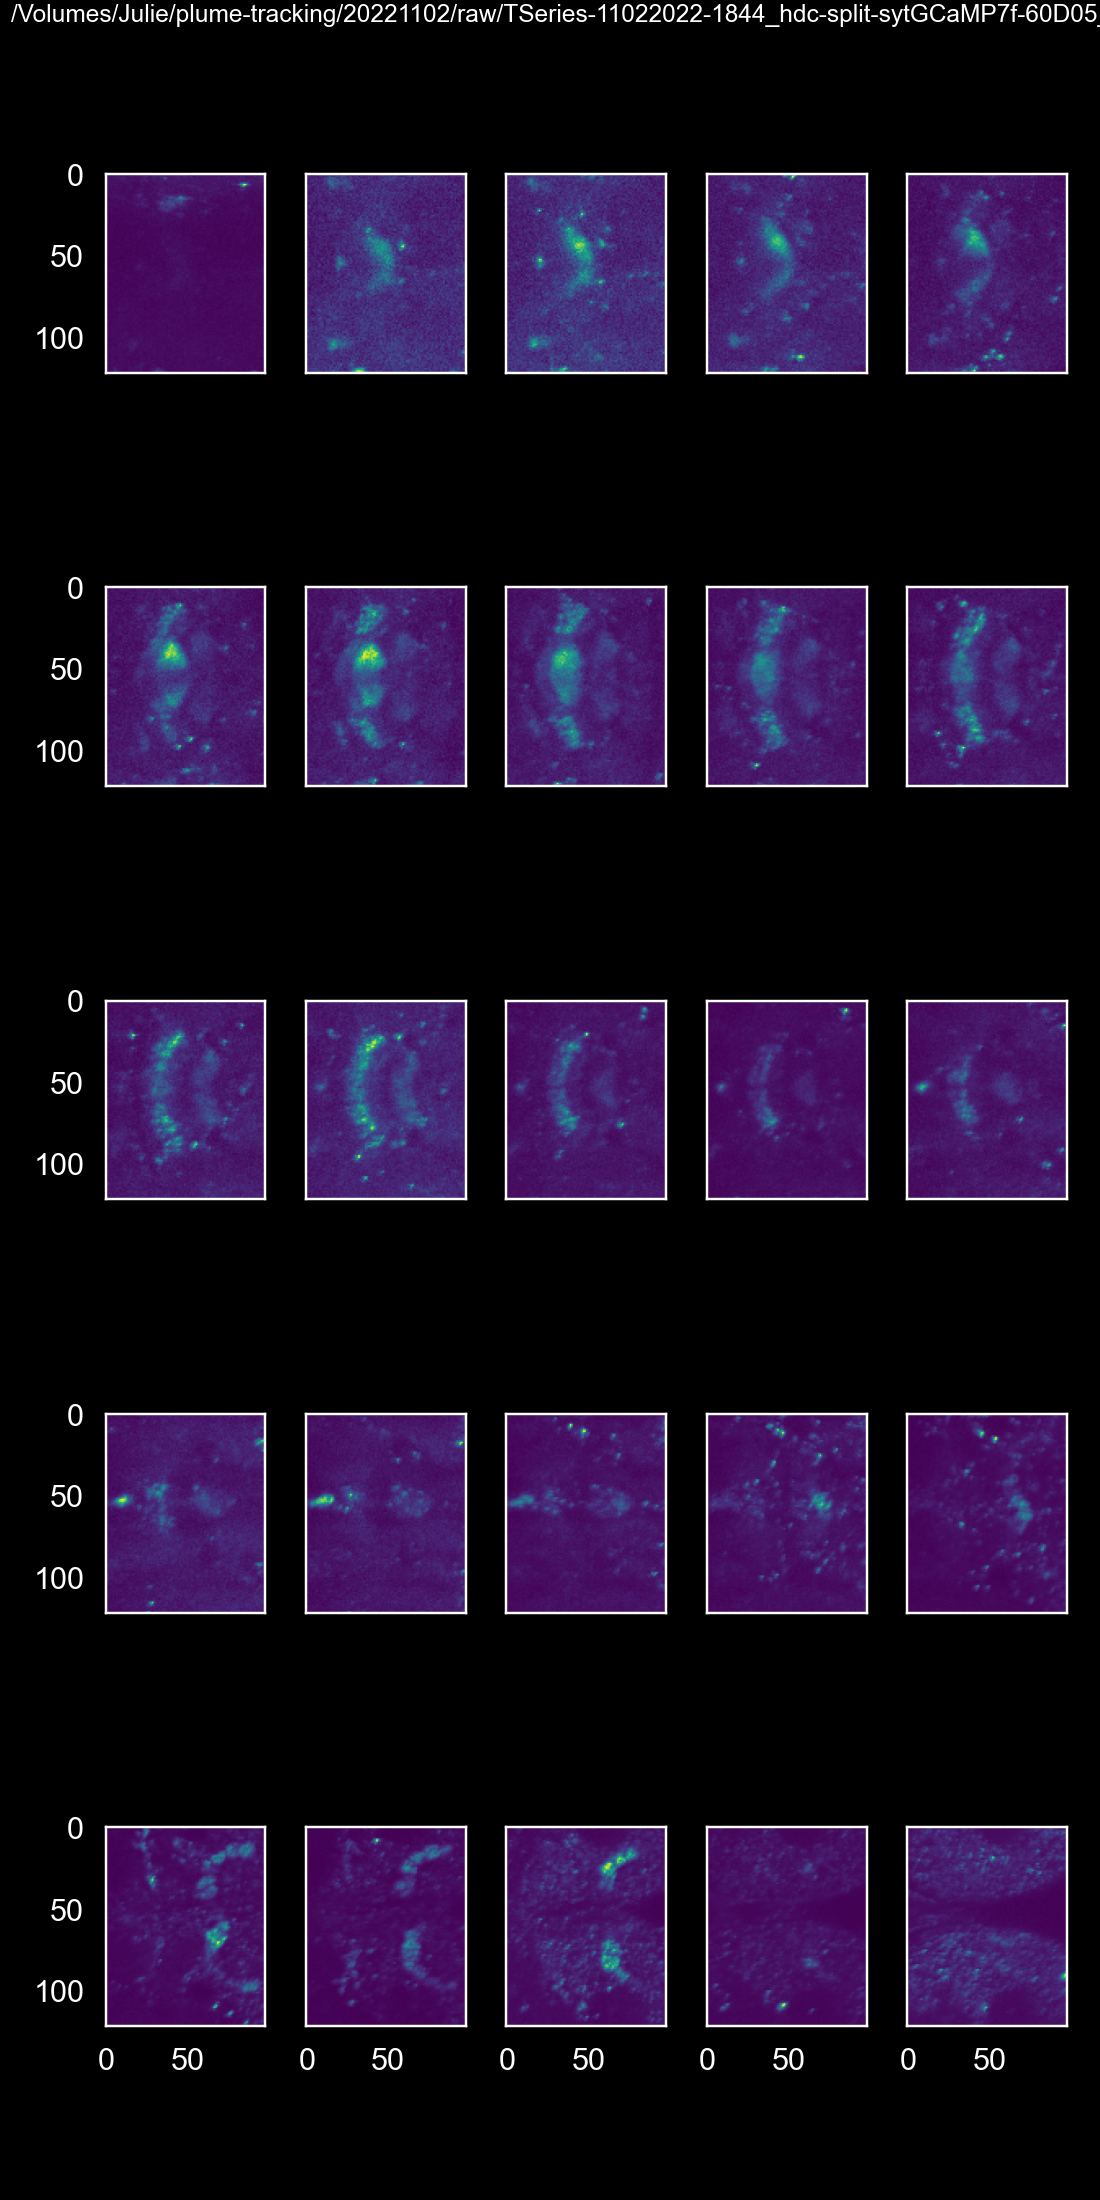

In [284]:
fig = anat.plot_average_slices(dst_dir=save_dir, save=True)

# Func volume

In [285]:
tif_fn = filedict[1]['tif_stack']
stk = ig.ImageStack(os.path.splitext(tif_fn)[0], n_slices=5) #, n_volumes=100)

savedir_func = os.path.join(dst_dir, stk.name)
if not os.path.exists(savedir_func):
    os.makedirs(savedir_func)
print(savedir_func)


/Users/julianarhee/miniforge3/envs/plume/lib/python3.9/site-packages/tifffile/tifffile.py:12998: RuntimeWarning: invalid value encountered in divide
  'ZDistance': values[:, 0] / values[:, 1],


/Volumes/Julie/plume-tracking/20221102/processed/TSeries-11022022-1844_hdc-split-sytGCaMP7f-60D05_fly4_stripgrid-001


In [286]:
im = stk.imread()
im.shape

(3607, 5, 83, 63)

In [287]:
func_avg = stk.average_volumes(dst_dir=savedir_func, save=True)
savedir_func

'/Volumes/Julie/plume-tracking/20221102/processed/TSeries-11022022-1844_hdc-split-sytGCaMP7f-60D05_fly4_stripgrid-001'

<IPython.core.display.Javascript object>


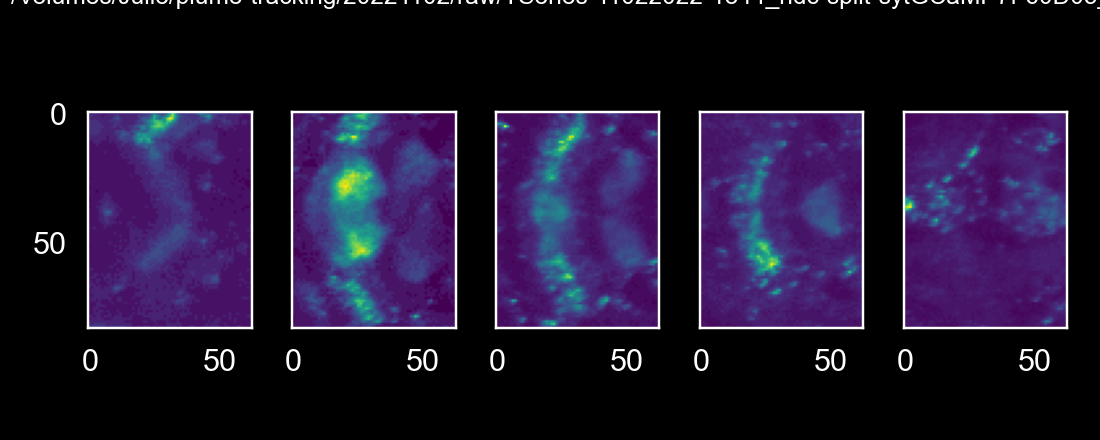

In [288]:
# fig, axn = pl.subplots(1, 5, sharex=True, sharey=True)
# for ax, ai in zip(axn.flat, range(stk.n_slices)):
#     ax.imshow(func_avg[ai, :, :], cmap=cmap)
# pl.tight_layout()
# util.label_figure(fig, stk.tif_fpath)
# figname = '{}'.format(stk.name)
# pl.savefig(os.path.join(dst_dir, 'slices_{}.png'.format(figname)))
fig = stk.plot_average_slices(dst_dir=savedir_func, save=True)

## Look at 1

In [45]:
file_ix = 0
file_info = filedict[file_ix]
ftpath = file_info['ft_fpath']
imdir = file_info['image_dir']

In [46]:
#print(fpath, air_only)
exp, date_str, fly_id, cond = butil.parse_info_from_file(ftpath)
print(date_str, fly_id, cond)
df0 = butil.load_dataframe(ftpath, mfc_id=None, verbose=False, cond=cond)

11022022-174454 fly3 hdc-sytgcamp7f


In [47]:
#odor_cond = 'hdc-sytgcamp7f'
odor_width=10
grid_sep=200
# get odor border for each fly
ogrid = butil.get_odor_grid(df0, 
                    odor_width=odor_width, grid_sep=grid_sep,
                    use_crossings=True, verbose=False)
ogrid
odor_bounds = list(ogrid.values())
ogrid

Crossings? True


{'c4464': (-3.30315865592591, 6.7012158175868874)}

<IPython.core.display.Javascript object>


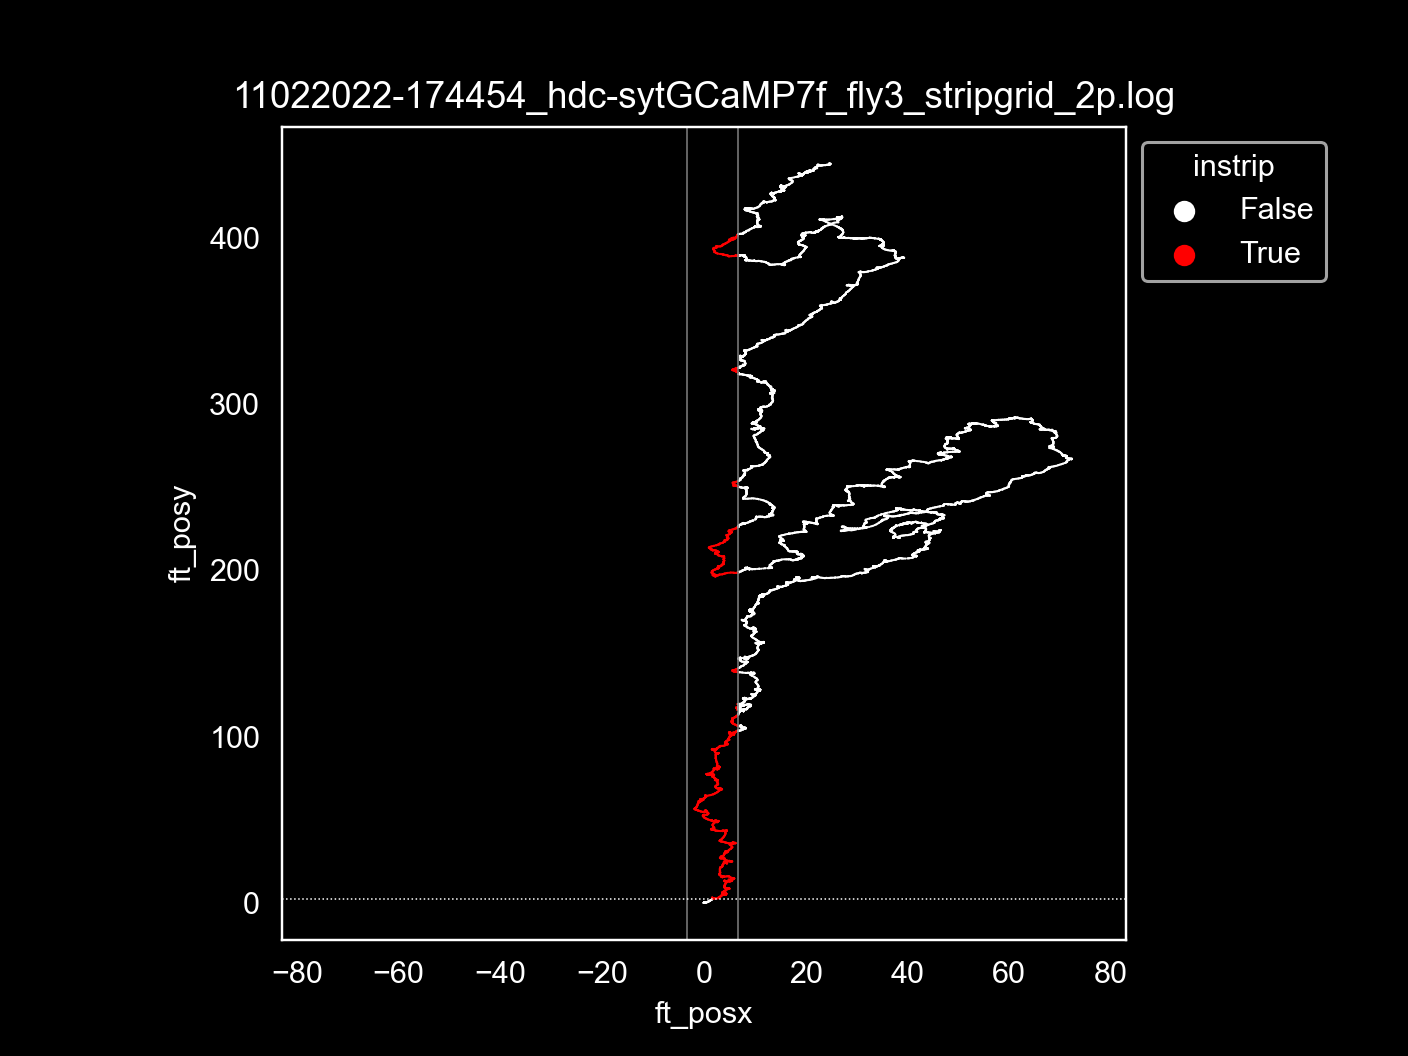

Text(0.5, 1.0, '11022022-174454_hdc-sytGCaMP7f_fly3_stripgrid_2p.log')

In [50]:
fig, ax= pl.subplots()
butil.plot_trajectory(df0, odor_bounds=odor_bounds, ax=ax)
ax.set_title(os.path.split(ftpath)[-1])

In [291]:
16970/5.

3394.0